In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.contrib.tensorboard.plugins import projector
from model import Model,load_training_data, plot_data, plot_z_run

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
config = {}  # Put all configuration information into the dict
config['num_layers'] = 2  # number of layers of stacked RNN's
config['hidden_size'] = 90  # memory cells in a layer
config['max_grad_norm'] = 5  # maximum gradient norm during training
config['batch_size'] = batch_size = 64
config['learning_rate'] = .005
config['crd'] = 1  # Hyperparameter for future generalization
config['num_l'] = 20  # number of units in the latent space

plot_every = 100  # after _plot_every_ GD steps, there's console output
max_iterations = 1000  # maximum number of iterations
dropout = 0.8  # Dropout rate

In [4]:
"""Load the data"""
data = data_utils.load_training_data()
X_train = data[:6000,:]
X_val = data[6000:,:]
N = X_train.shape[0]
Nval = X_val.shape[0]
D = X_train.shape[1]
config['sl'] = sl = D  # sequence length
print('We have %s observations with %s dimensions' % (N, D))

We have 6000 observations with 128 dimensions


In [5]:
# Proclaim the epochs
epochs = np.floor(batch_size * max_iterations / N)
print('Train with approximately %d epochs' % epochs)

"""Training time!"""
model = Model(config)
sess = tf.Session()
perf_collect = np.zeros((2, int(np.floor(max_iterations / plot_every))))
if True:
    sess.run(model.init_op)
    

    step = 0  # Step is a counter for filling the numpy array perf_collect
    for i in range(max_iterations):
        batch_ind = np.random.choice(N, batch_size, replace=False)
        result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.train_step],
                          feed_dict={model.x: X_train[batch_ind], model.keep_prob: dropout})

        if i % plot_every == 0:
            # Save train performances
            perf_collect[0, step] = loss_train = result[0]
            loss_train_seq, lost_train_lat = result[1], result[2]

            # Calculate and save validation performance
            batch_ind_val = np.random.choice(Nval, batch_size, replace=False)

            result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.merged],
                              feed_dict={model.x: X_val[batch_ind_val], model.keep_prob: 1.0})
            perf_collect[1, step] = loss_val = result[0]
            loss_val_seq, lost_val_lat = result[1], result[2]
            # and save to Tensorboard
            summary_str = result[3]
         

            print("At %6s / %6s train (%5.3f, %5.3f, %5.3f), val (%5.3f, %5.3f,%5.3f) in order (total, seq, lat)" % (
            i, max_iterations, loss_train, loss_train_seq, lost_train_lat, loss_val, loss_val_seq, lost_val_lat))
            step += 1

Train with approximately 10 epochs
At      0 /   1000 train (2.775, 0.950, 1.825), val (1.579, 0.840,0.739) in order (total, seq, lat)
At    100 /   1000 train (0.462, 0.452, 0.010), val (0.470, 0.470,0.000) in order (total, seq, lat)
At    200 /   1000 train (0.581, 0.576, 0.005), val (0.521, 0.520,0.001) in order (total, seq, lat)
At    300 /   1000 train (0.593, 0.587, 0.006), val (0.574, 0.573,0.001) in order (total, seq, lat)
At    400 /   1000 train (0.356, 0.344, 0.012), val (0.806, 0.798,0.008) in order (total, seq, lat)
At    500 /   1000 train (0.343, 0.332, 0.011), val (0.317, 0.309,0.008) in order (total, seq, lat)
At    600 /   1000 train (-0.178, -0.181, 0.003), val (-0.155, -0.156,0.001) in order (total, seq, lat)
At    700 /   1000 train (0.426, 0.422, 0.005), val (0.391, 0.390,0.001) in order (total, seq, lat)
At    800 /   1000 train (-0.177, -0.183, 0.006), val (-0.304, -0.306,0.002) in order (total, seq, lat)
At    900 /   1000 train (-0.291, -0.298, 0.007), val (-0

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1344 samples in 0.002s...
[t-SNE] Computed neighbors for 1344 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1344
[t-SNE] Computed conditional probabilities for sample 1344 / 1344
[t-SNE] Mean sigma: 0.014162
[t-SNE] Computed conditional probabilities in 0.116s
[t-SNE] Iteration 50: error = 52.5557442, gradient norm = 0.1444395 (50 iterations in 2.641s)
[t-SNE] Iteration 100: error = 48.3108597, gradient norm = 0.0482290 (50 iterations in 2.080s)
[t-SNE] Iteration 150: error = 47.5719337, gradient norm = 0.0340796 (50 iterations in 1.973s)
[t-SNE] Iteration 200: error = 47.2732811, gradient norm = 0.0230131 (50 iterations in 2.003s)
[t-SNE] Iteration 250: error = 47.1011124, gradient norm = 0.0264680 (50 iterations in 1.898s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.101112
[t-SNE] Iteration 300: error = 0.2962743, gradient norm = 0.0006515 (50 iterations in 2.121s

NameError: name 'LOG_DIR' is not defined

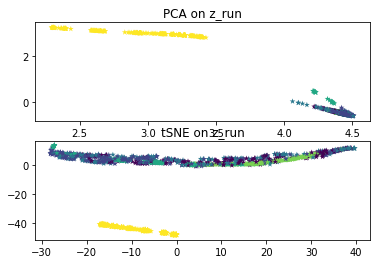

In [7]:
LABLE_DATA_FILE = "dataset/train/y_train.txt"
label = np.loadtxt(LABLE_DATA_FILE)
y_train = label[:6000]
y_val = label[6000:]
if True:
    ##Extract the latent space coordinates of the validation set
    start = 0
    label = []  # The label to save to visualize the latent space
    z_run = []

    while start + batch_size < Nval:
        run_ind = range(start, start + batch_size)
        z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: X_val[run_ind], model.keep_prob: 1.0})
        z_run.append(z_mu_fetch)
        start += batch_size

    z_run = np.concatenate(z_run, axis=0)
    label = y_val[:start]

    plot_z_run(z_run, label)

# Save the projections also to Tensorboard
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), step)
config = projector.ProjectorConfig()
# You can add multiple embeddings. Here we add only one.
embedding = config.embeddings.add()
embedding.tensor_name = model.z_mu.name
# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

# Saves a configuration file that TensorBoard will read during startup.
projector.visualize_embeddings(writer, config)
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), step + 1)
# Now open Tensorboard with
#  $tensorboard --logdir = LOG_DIR





